# khipu dev, testing transformed graphs (U, E) to (E, V)

Because edges correspond to unique mass difference in data, I explored the use of edges to align compound to khipu grid here. But it does not appear to be a good solution, because E are not unique when mapped back to ions.

2022-12-22

In [1]:
!pip install --upgrade khipu-metabolomics

     |████████████████████████████████| 7.4MB 280kB/s eta 0:00:01
     |████████████████████████████████| 829kB 16.9MB/s eta 0:00:01
  Created wheel for treelib: filename=treelib-1.6.1-cp37-none-any.whl size=18369 sha256=240116029189beeba53a54a8748535539712bf9d9d4502f83c2d91d7e5709e38
  Stored in directory: /home/jovyan/.cache/pip/wheels/68/1d/92/c50ec52951ccebafb40f3b8f0beb28fbaf745431c14a17c497
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491057 sha256=a13738da7c4b48e02ed80673bb0cee71d8cb1fc99569c04dc562387fde7df443
  Stored in directory: /home/jovyan/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built treelib future


In [38]:
import treelib
import matplotlib.pyplot as plt
from khipu.test import *

In [3]:
# Read test feature table into khipu package
subnetworks, peak_dict, edge_dict = test_read_url()
print(len(subnetworks), len(peak_dict))
# Have a look at peak data structure
print(list(peak_dict.items())[55:57])

Retrieving test data from GitHub.
table headers ordered:  mz rtime
Read 4016 feature lines
681 4016
[('F56', {'id': 'F56', 'mz': 119.0725, 'rtime': 151.44, 'intensities': [526144.0, 0.0, 0.0, 0.0], 'representative_intensity': 131536.0}), ('F57', {'id': 'F57', 'mz': 119.0834, 'rtime': 128.05, 'intensities': [469938.0, 0.0, 681936.0, 288568.0], 'representative_intensity': 360110.5})]


In [4]:
# Have a look at default ion patterns

print(isotope_search_patterns)

print(adduct_search_patterns)

[(1.003355, '13C/12C', (0, 0.8)), (2.00671, '13C/12C*2', (0, 0.8)), (3.010065, '13C/12C*3', (0, 0.8)), (4.01342, '13C/12C*4', (0, 0.8)), (5.016775, '13C/12C*5', (0, 0.8)), (6.02013, '13C/12C*6', (0, 0.8)), (7.023485, '13C/12C*7', (0, 0.8)), (8.02684, '13C/12C*8', (0, 0.8)), (9.030195, '13C/12C*9', (0, 0.8)), (10.03355, '13C/12C*10', (0, 0.8)), (11.036905, '13C/12C*11', (0, 0.8)), (12.04026, '13C/12C*12', (0, 0.8))]
[(21.982, 'Na/H'), (41.026549, 'Acetonitrile'), (17.02655, 'NH3'), (35.9767, 'HCl'), (37.955882, 'K/H')]


In [6]:
sizes = [n.number_of_nodes() for n in subnetworks]
# choose one group to build demo khipu
for ii in range(20):
    print(ii, sizes[ii])

0 2
1 3
2 3
3 16
4 3
5 4
6 4
7 21
8 4
9 7
10 13
11 24
12 13
13 4
14 20
15 3
16 5
17 3
18 5
19 2


In [7]:
G = subnetworks[7]

In [31]:
node_dict = dict(zip(G.nodes(), [peak_dict[n]['mz'] for n in G.nodes()]))

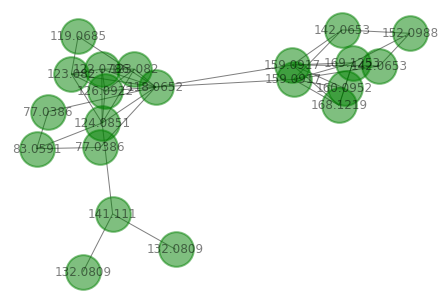

In [32]:
nx.draw(G, node_size=1200, node_color='g', linewidths=2, with_labels=1, alpha=0.5, labels=node_dict)

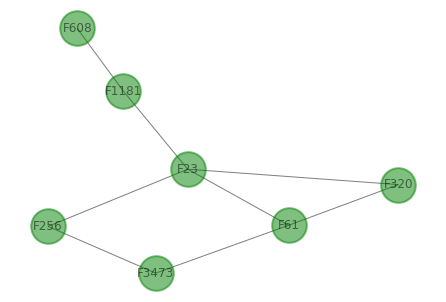

In [30]:
nx.draw(subnetworks[9], node_size=1200, node_color='g', linewidths=2, with_labels=1, alpha=0.5)# , labels=node_dict)

In [34]:
def make_expected_adduct_index(mode='pos', 
                               pattern=[(21.9820, 'Na/H'), (41.026549, 'ACN')]):
    '''Construct the adduct list for a core list of adduct m/z diff patterns. 
    Use neutral mass as 0 offset, so that later regression will compute neutral mass.
    Not modify adduct tag, so that the edges can be later mapped correctly.
    '''
    if mode == 'pos':
        # pos base ion as M+H+
        return [(PROTON, 'M+H+'), ] + [(x[0] + PROTON, x[1]) for x in pattern] 
    else:
        # neg base ion as M-H[-]
        return [-PROTON, 'M-H[-]'] + [(x[0] - PROTON, x[1]) for x in pattern]


In [36]:
PROTON = 1.00727646677

adduct_pattern = make_expected_adduct_index('pos', adduct_search_patterns)
adduct_pattern

[(1.00727646677, 'M+H+'),
 (22.98927646677, 'Na/H'),
 (42.033825466770004, 'Acetonitrile'),
 (18.03382646677, 'NH3'),
 (36.98397646677, 'HCl'),
 (38.963158466770004, 'K/H')]

In [37]:
isotope_index = ['M0'] + [x[1] for x in isotope_search_patterns]
isotope_index

['M0',
 '13C/12C',
 '13C/12C*2',
 '13C/12C*3',
 '13C/12C*4',
 '13C/12C*5',
 '13C/12C*6',
 '13C/12C*7',
 '13C/12C*8',
 '13C/12C*9',
 '13C/12C*10',
 '13C/12C*11',
 '13C/12C*12']

In [41]:
def make_tree(adduct_pattern, isotope_index):
    tree = treelib.Tree()
    tree.create_node('M', 'M')
    for node in adduct_pattern:
        tree.create_node(node, node, parent='M')
        for m in isotope_index:
            tree.create_node(m, m+node, parent=node)
    return tree

In [47]:
tree = make_tree([x[1] for x in adduct_pattern], isotope_index[:3])

In [48]:
tree.show()

M
├── Acetonitrile
│   ├── 13C/12C
│   ├── 13C/12C*2
│   └── M0
├── HCl
│   ├── 13C/12C
│   ├── 13C/12C*2
│   └── M0
├── K/H
│   ├── 13C/12C
│   ├── 13C/12C*2
│   └── M0
├── M+H+
│   ├── 13C/12C
│   ├── 13C/12C*2
│   └── M0
├── NH3
│   ├── 13C/12C
│   ├── 13C/12C*2
│   └── M0
└── Na/H
    ├── 13C/12C
    ├── 13C/12C*2
    └── M0



In [49]:
subnetworks[9].edges(data=True)

EdgeDataView([('F320', 'F23', {'type': 'isotope', 'tag': '13C/12C*5'}), ('F320', 'F61', {'type': 'isotope', 'tag': '13C/12C*4'}), ('F256', 'F3473', {'type': 'isotope', 'tag': '13C/12C'}), ('F256', 'F23', {'type': 'modification', 'tag': 'K/H'}), ('F1181', 'F23', {'type': 'modification', 'tag': 'Na/H'}), ('F1181', 'F608', {'type': 'modification', 'tag': 'K/H'}), ('F3473', 'F61', {'type': 'modification', 'tag': 'K/H'}), ('F61', 'F23', {'type': 'isotope', 'tag': '13C/12C'})])

In [ ]:
for node in subnetworks[9].nodes():
    for n2 in node.succesors():
        print()

In [57]:
subnetworks[9].adj

AdjacencyView({'F320': {'F23': {'type': 'isotope', 'tag': '13C/12C*5'}, 'F61': {'type': 'isotope', 'tag': '13C/12C*4'}}, 'F256': {'F3473': {'type': 'isotope', 'tag': '13C/12C'}, 'F23': {'type': 'modification', 'tag': 'K/H'}}, 'F1181': {'F23': {'type': 'modification', 'tag': 'Na/H'}, 'F608': {'type': 'modification', 'tag': 'K/H'}}, 'F3473': {'F256': {'type': 'isotope', 'tag': '13C/12C'}, 'F61': {'type': 'modification', 'tag': 'K/H'}}, 'F608': {'F1181': {'type': 'modification', 'tag': 'K/H'}}, 'F61': {'F320': {'type': 'isotope', 'tag': '13C/12C*4'}, 'F3473': {'type': 'modification', 'tag': 'K/H'}, 'F23': {'type': 'isotope', 'tag': '13C/12C'}}, 'F23': {'F320': {'type': 'isotope', 'tag': '13C/12C*5'}, 'F256': {'type': 'modification', 'tag': 'K/H'}, 'F1181': {'type': 'modification', 'tag': 'Na/H'}, 'F61': {'type': 'isotope', 'tag': '13C/12C'}}})

In [59]:
enodes = [e[2]['tag'] for e in subnetworks[9].edges(data=True)]
enodes = list(set(enodes))

# use bipartite to convert 
BG = nx.Graph()
BG.add_nodes_from(list(subnetworks[9].nodes()), bipartite=0)
BG.add_nodes_from(enodes, bipartite=1)


In [62]:
BG.nodes()

NodeView(('F320', 'F256', 'F1181', 'F3473', 'F608', 'F61', 'F23', 'Na/H', '13C/12C*5', '13C/12C', '13C/12C*4', 'K/H'))

In [63]:
bg_edges = []
for e in subnetworks[9].edges(data=True):
    bg_edges.append((e[0], e[2]['tag']))
    bg_edges.append((e[2]['tag'], e[1]))

BG.add_edges_from(bg_edges)

In [64]:
BG.edges()

EdgeView([('F320', '13C/12C*5'), ('F320', '13C/12C*4'), ('F256', '13C/12C'), ('F256', 'K/H'), ('F1181', 'Na/H'), ('F1181', 'K/H'), ('F3473', '13C/12C'), ('F3473', 'K/H'), ('F608', 'K/H'), ('F61', '13C/12C*4'), ('F61', 'K/H'), ('F61', '13C/12C'), ('F23', '13C/12C*5'), ('F23', 'K/H'), ('F23', 'Na/H'), ('F23', '13C/12C')])

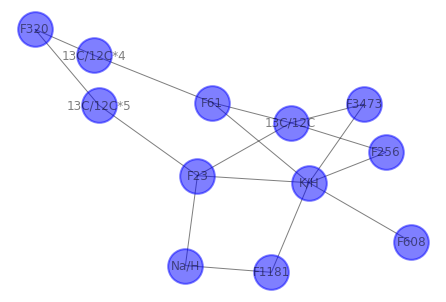

In [65]:
nx.draw(BG, node_size=1200, node_color='b', linewidths=2, with_labels=1, alpha=0.5)

In [66]:
from networkx.algorithms import bipartite

In [67]:
inv = bipartite.projected_graph(BG, enodes)

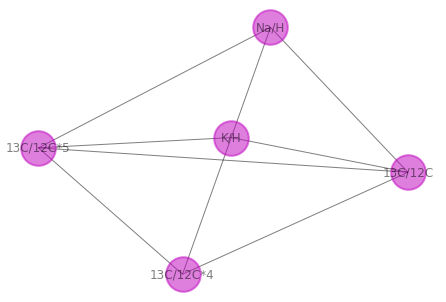

In [68]:
nx.draw(inv, node_size=1200, node_color='m', linewidths=2, with_labels=1, alpha=0.5)

# Conclusion

E are not unique when mapped back to ions. The bag and branch method earlier works better.